<center>
<h1> SOLUCIÓN TAREA 4</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>


In [1]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance,standard_deviation,mean
from scipy.stats import variation

In [2]:
import cv2
from IPython.display import Image
import numpy as np
from matplotlib import pyplot as plt
from math import nan

Se carga la imágen con la que se trabajara en la primera y segunda parte de la tarea, a la cual se le añade ruido Speckle con una distribución de media cero y varianza 0.04:

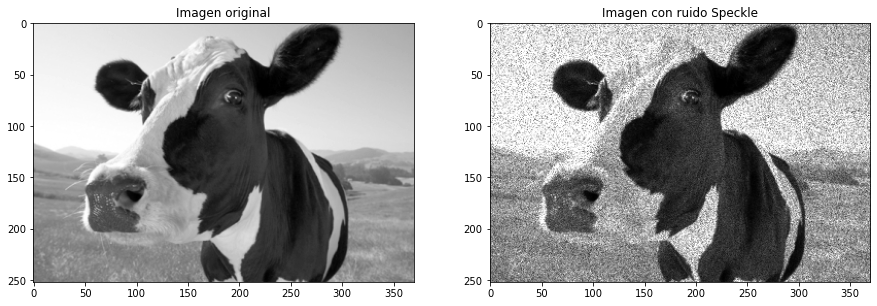

In [48]:
from skimage.util import random_noise

#img = cv2.imread('fig/fig2.png',0)
img = cv2.imread('fig/img.jpg',0)

noise_img = random_noise(img, mode='speckle',mean=0,var=0.04,seed=42)

# Multiplicamos por 255 ya que la funcion random_noise nos devuelve
# los valores en un rango de [0, 1] y de esta manera obtendremos que
# sean valores de [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')

plt.figure(1, figsize=[15,15])
plt.subplot(121).imshow(img,cmap='gray')
plt.title('Imagen original')
plt.subplot(122).imshow(noise_img,cmap='gray')
plt.title('Imagen con ruido Speckle')
plt.show()

<h1>PRIMER PUNTO</h1> Implementar, en OpenCV, tres de los filtros para reducción de ruido Speckle vistos en clase.

Antes de empezar a definir los filtro definimos una función para limitar los indices de los filtros y de esta manera no halla errores respectivos al tamaño o a los bordes:

In [6]:
def assert_indices_in_range(width, height, xleft, xright, yup, ydown):
    """
    Asserts index out of image range.
    """
    assert xleft >= 0 and xleft <= width, \
        "index xleft:%s out of range (%s<= xleft < %s)" % (xleft, 0, width)

    assert xright >= 0 and xright <= width, \
        "index xright:%s out of range (%s<= xright < %s)" % (xright, 0, width)

    assert yup >= 0 and yup <= height, \
        "index yup:%s out of range. (%s<= yup < %s)" % (yup, 0, height)

    assert ydown >= 0 and ydown <= height, \
        "index ydown:%s out of range. (%s<= ydown < %s)" % (ydown, 0, height)

Empezamos definiendo el primer filtro conocido como el filtro de Lee, posteriormente definiremos una generalización de este conocido como el filtro de Kuan y por ultimo implementaremos el filtro de frost:

<h1> FILTRO DE LEE </h1>

In [9]:
def weighting_lee(window, cu=0.25):
    
    """
    Función para calcular la función de peso en el filtro de Lee.
    """
    COEF_VAR_DEFAULT = 0.01
    # cu es el coeficiente de variación del ruido
    two_cu = cu * cu

    # ci coeficiente de variación en la ventana
    window_mean = window.mean()
    window_std = window.std()
    if window_mean==0: 
        ci = np.sqrt(COEF_VAR_DEFAULT)
        two_ci = COEF_VAR_DEFAULT
    else:
        ci = window_std / window_mean
        two_ci = ci * ci

    if cu > ci:
        w_t = 0
    else:
        w_t = 1.0 - (two_cu / two_ci)

    return w_t


def lee_filter(img, win_size=6, cu=0.25):

    img = np.float64(img)
    img_filtered = np.zeros_like(img)
    N, M = img.shape
    win_offset = int(win_size/2)

    for i in range(0, N):
        xleft = i - win_offset
        xright = i + win_offset

        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N

        for j in range(0, M):
            yup = j - win_offset
            ydown = j + win_offset

            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M

            assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            pix_value = img[i, j]
            window = img[xleft:xright, yup:ydown]
            w_t = weighting_lee(window, cu)
            window_mean = window.mean()
            new_pix_value = (pix_value * w_t) + (window_mean * (1.0 - w_t))
            
            img_filtered[i, j] = new_pix_value

    return img_filtered

<h1> FILTRO DE KUAN

In [10]:
def weighting_kuan(window, cu=0.25):
    """
    Función para calcular la función de peso en el filtro de Kuan.
    """
    two_cu = cu * cu

    ci = variation(window, None)
    two_ci = ci * ci

    if not two_ci: 
        two_ci = 0.01

    divisor = 1.0 + two_cu

    if not divisor:
        divisor = 0.0001

    if cu > ci:
        w_t = 0.0
    else:
        w_t = (1.0 - (two_cu / two_ci)) / divisor

    return w_t


def kuan_filter(img, win_size=3, cu=0.25):
    """
    Aplica el filtro de kuan a la imagen, con una ventana de win_size x win_size.
    """
    img = np.float64(img)
    img_filtered = np.zeros_like(img)

    N, M = img.shape
    # win_offset = win_size / 2
    win_offset = int(win_size / 2)

    for i in np.arange(0, N):
        xleft = i - win_offset
        xright = i + win_offset

        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N

        for j in np.arange(0, M):
            yup = j - win_offset
            ydown = j + win_offset

            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M

            pix_value = img[i, j]
            window = img[xleft:xright, yup:ydown]
            w_t = weighting_kuan(window, cu)
            window_mean = window.mean()
            new_pix_value = (pix_value * w_t) + (window_mean * (1.0 - w_t))

            if (new_pix_value is None) or np.isnan(new_pix_value):
                new_pix_value = 0

            img_filtered[i, j] = round(new_pix_value)

    return img_filtered

<h1> FILTRO DE FROST

In [13]:
def compute_coef_var(image, x_start, x_end, y_start, y_end):
    """
    Calcula el coeficiente de variación en una ventana de [x_start: x_end] y
    [y_start:y_end] dentro de la imagen.
    """
    COEF_VAR_DEFAULT=0.01
    assert x_start >= 0, 'ERROR: x_start must be >= 0.'
    assert y_start >= 0, 'ERROR: y_start must be >= 0.'

    x_size, y_size = image.shape
    x_overflow = x_end > x_size
    y_overflow = y_end > y_size

    assert not x_overflow, 'ERROR: invalid parameters cause x window overflow.'
    assert not y_overflow, 'ERROR: invalid parameters cause y window overflow.'

    window = image[x_start:x_end, y_start:y_end]

    coef_var = variation(window, None)

    if coef_var != nan :  # dirty patch
        coef_var = COEF_VAR_DEFAULT
    #print(window,coef_var)
    return coef_var


def calculate_all_Mi(window_flat, factor_A, window):
    """
    Calcula todos los pesos de los píxeles de la ventana.
    """
    N, M = window.shape
    center_pixel = np.float64(window[N//2, M//2])
    window_flat = np.float64(window_flat)

    distances = np.abs(window_flat - center_pixel)

    weights = np.exp(-factor_A * distances)

    return weights


def calculate_local_weight_matrix(window, factor_A):
    """
    Devuelve un array con los pesos de los píxeles de la ventana dada.
    """
    weights_array = np.zeros(window.size)
    window_flat = window.flatten()

    weights_array = calculate_all_Mi(window_flat, factor_A, window)

    return weights_array


def frost_filter(img, damping_factor=2.0, win_size=6):
    """
    Aplica el filtro frost a la imagen, con una ventana de
    win_size x win_size.
    """
    img_filtered = np.zeros_like(img)
    N, M = img.shape
    #N, M = (20,20)
    win_offset = int(win_size / 2)

    for i in range(0, N):
        xleft = i - win_offset
        xright = i + win_offset
        if xleft < 0:
            xleft = 0
        if xright >= N:
            xright = N - 1
        for j in range(0, M):
            yup = j - win_offset
            ydown = j + win_offset
            if yup < 0:
                yup = 0
            if ydown >= M:
                ydown = M - 1

            assert_indices_in_range(N, M, xleft, xright, yup, ydown)

            variation_coef = compute_coef_var(img, xleft, xright, yup, ydown)
            window = img[xleft:xright, yup:ydown]
            window_mean = window.mean()
            if window_mean==0:
                sigma_zero = 0
            else:
                sigma_zero = variation_coef / window_mean# var / u^2
            factor_A = damping_factor * sigma_zero

            weights_array = calculate_local_weight_matrix(window, factor_A)
            pixels_array = window.flatten()

            weighted_values = weights_array * pixels_array
            #print(variation_coef,window_mean,sigma_zero,factor_A,weights_array,pixels_array)
            img_filtered[i, j] = weighted_values.sum() / weights_array.sum()

    return img_filtered

Una vez implementados los 3 filtros, procedemos a utilizarlos con la imagen ruidosa configurando sus parametros para obtener un resultado similar en las salidas de los filtros:

In [14]:
lee=lee_filter(noise_img,6,0.5)
kuan=kuan_filter(noise_img,7,0.5)
frost=frost_filter(noise_img,2,6)

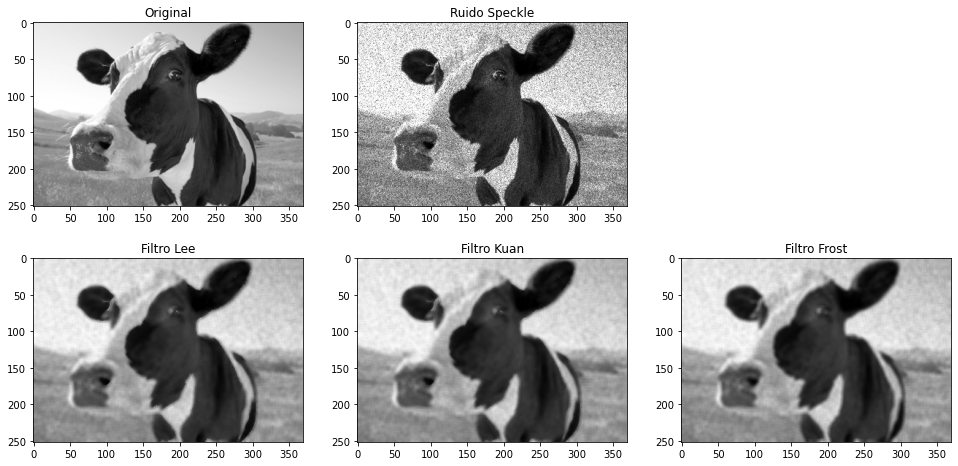

In [15]:
plt.figure(1,figsize=[15,15])
plt.subplot(231).imshow(img,cmap='gray')
plt.title('Original')
plt.subplot(232).imshow(noise_img,cmap='gray')
plt.title('Ruido Speckle')
plt.subplot(234).imshow(lee,cmap='gray')
plt.title('Filtro Lee')
plt.subplot(235).imshow(kuan,cmap='gray')
plt.title('Filtro Kuan')
plt.subplot(236).imshow(frost,cmap='gray')
plt.title('Filtro Frost')
plt.subplots_adjust(top=0.95, bottom=0.55, left=0.10, right=0.95)
plt.show()

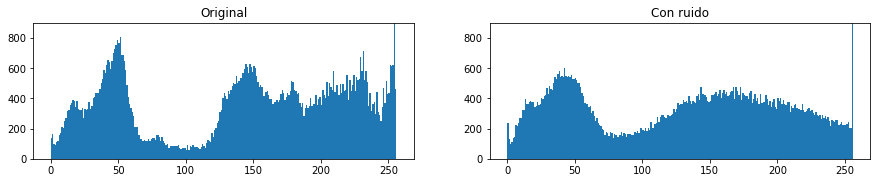

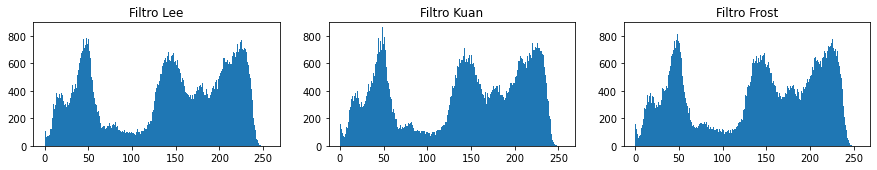

In [17]:
plt.figure(1,figsize=[15,2.5])
plt.subplot(121).hist(img.ravel(),256,[0,256])
plt.title('Original')
plt.ylim(0, 900)
plt.subplot(122).hist(noise_img.ravel(),256,[0,256])
plt.title('Con ruido')
plt.ylim(0, 900)
plt.figure(2,figsize=[15,5])
plt.subplot(234).hist(lee.ravel(),256,[0,256])
plt.title('Filtro Lee')
plt.ylim(0, 900)
plt.subplot(235).hist(kuan.ravel(),256,[0,256])
plt.title('Filtro Kuan')
plt.ylim(0, 900)
plt.subplot(236).hist(frost.ravel(),256,[0,256])
plt.title('Filtro Frost')
plt.ylim(0, 900)
plt.show()

Podemos ver como el histograma de la imagen original se ve afectado por el ruido Speckle pero gracias a los filtros recuperamos gran parte de la información de la imagen original y filtramos en gran parte del ruido.

Veamos el efecto de cambiar la ventana de trabajo del filtro:

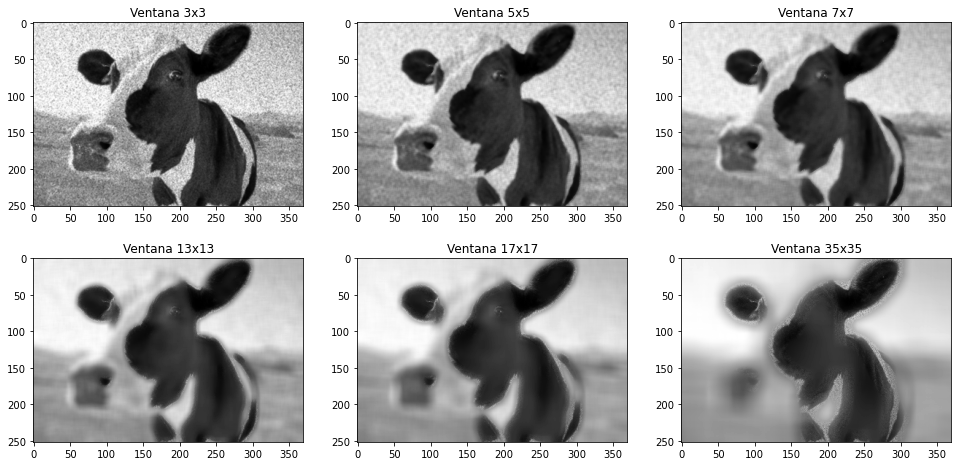

In [51]:
plt.figure(1,figsize=[15,15])
plt.subplot(231).imshow(kuan_filter(noise_img,3,0.5),cmap='gray')
plt.title('Ventana 3x3')
plt.subplot(232).imshow(kuan_filter(noise_img,5,0.5),cmap='gray')
plt.title('Ventana 5x5')
plt.subplot(233).imshow(kuan_filter(noise_img,7,0.5),cmap='gray')
plt.title('Ventana 7x7')
plt.subplot(234).imshow(kuan_filter(noise_img,13,0.5),cmap='gray')
plt.title('Ventana 13x13')
plt.subplot(235).imshow(kuan_filter(noise_img,17,0.5),cmap='gray')
plt.title('Ventana 17x17')
plt.subplot(236).imshow(kuan_filter(noise_img,35,0.5),cmap='gray')
plt.title('Ventana 35x35')
plt.subplots_adjust(top=0.95, bottom=0.55, left=0.10, right=0.95)


Como podemos ver entre mas grande sea la ventana que tomamos el suavizado de la imagen sera mucho mayor.

<h1>SEGUNDO PUNTO</h1>Implementar, en OpenCV, cinco de las técnicas de estimación del nivel de ruido vistas en clase.

<h2>Relación señal a ruido (SNR)

In [18]:
def signaltonoise(Arr):
    return np.mean(Arr)/np.std(Arr)

Luego de definir la función de señal a ruido de una imágen se muestran los valores de este parámetro para las imágenes del prueba, el filtro Frost tiene una mayor relación señal a ruido lo que muestra un mejor desempeño con los parametros impuestos.

In [19]:
snr_img=signaltonoise(img)
snr_noise=signaltonoise(noise_img)
snr_lee=signaltonoise(lee)
snr_kuan=signaltonoise(kuan)
snr_frost=signaltonoise(frost)
print('Original: ',"\t%.4f" % snr_img,'Con ruido: ',"%.4f" %snr_noise)
print('Filtros: Lee: ',"\t%.4f" % snr_lee,'Kuan: ',"%.4f" % snr_kuan, 'Frost: ',"%.4f" % snr_frost)

Original:  	1.8353 Con ruido:  1.7528
Filtros: Lee:  	1.9065 Kuan:  1.9101 Frost:  1.9140


Para comparar el SNR de las señales filtradas con la que tiene ruido se calcula la relación en decibelios y se verifica que el filtro de Frost presenta una mayor atenuación.

In [20]:
print('Lee: ',"\t%.4f db" % (10*np.log10(snr_noise/snr_lee)))
print('Kuan: ',"\t%.4f db" % (10*np.log10(snr_noise/snr_kuan)))
print('Frost:',"\t%.4f db" % (10*np.log10(snr_noise/snr_frost)))

Lee:  	-0.3652 db
Kuan:  	-0.3734 db
Frost: 	-0.3822 db


<h2>Número equivalente de vistas (ENL)

In [21]:
def enl(input):
    return (np.mean(input)**2)/(np.std(input)**2)

Se elige un área uniforme donde se calculará el enl, a continuación se muestran la porción de cada imágen y su enl en el título. En este caso el filtro de Lee muestra un rendimiento superior.

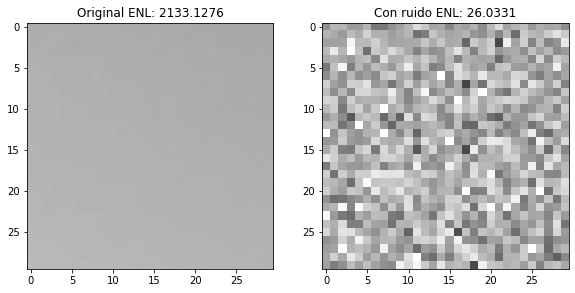

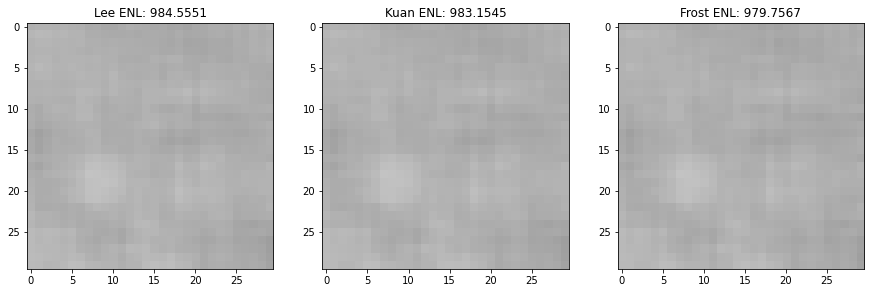

In [22]:
enl_img=enl(img[0:30,340:])
enl_noise=enl(noise_img[0:30,340:])
enl_lee=enl(lee[0:30,340:])
enl_kuan=enl(kuan[0:30,340:])
enl_frost=enl(frost[0:30,340:])

plt.figure(1,figsize=[15,15])
plt.subplot(131).imshow(img[0:30,340:],cmap='gray',vmin=0, vmax=255)
plt.title('Original ENL: %.4f' % enl_img)
plt.subplot(132).imshow(noise_img[0:30,340:],cmap='gray',vmin=0, vmax=255)
plt.title('Con ruido ENL: %.4f' % enl_noise)
plt.figure(2,figsize=[15,15])
plt.subplot(131).imshow(lee[0:30,340:],cmap='gray',vmin=0, vmax=255)
plt.title('Lee ENL: %.4f' % enl_lee)
plt.subplot(132).imshow(kuan[0:30,340:],cmap='gray',vmin=0, vmax=255)
plt.title('Kuan ENL: %.4f' % enl_kuan)
plt.subplot(133).imshow(frost[0:30,340:],cmap='gray',vmin=0, vmax=255)
plt.title('Frost ENL: %.4f' % enl_frost);

<h2>Indice de supresión de speckle (SSI)

In [23]:
def SSI(filtered, noised):
    return (np.std(filtered)/np.mean(filtered))*(np.mean(noised)/np.std(noised))

Este indice es menor que uno si es eficaz al reducir el ruido, en este caso el filtro de Frost muestra un mejor resultado.

In [24]:
print('Lee: ',"%.4f" % (SSI(lee, noise_img)))
print('Kuan: ',"%.4f" % (SSI(kuan, noise_img)))
print('Frost:',"%.4f" % (SSI(frost, noise_img)))

Lee:  0.9194
Kuan:  0.9176
Frost: 0.9158


<h2>Indice de preservado de la media y supresión del ruido speckle (SMPI)

In [25]:
def SMPI(img_rui,img_fil):
    Mo=1+np.abs(np.mean(img_rui)-np.mean(img_fil))
    SMPI_v = Mo*np.std(img_fil)/np.std(img_rui)
    return SMPI_v

Ya que el filtro de Kuan tiene un menor SMPI se puede decir que conserva mejor la imágen original al reducir el ruido.

In [26]:
print('Lee: ',"%.4f" % SMPI(noise_img,lee))
print('Kuan: ',"%.4f" % SMPI(noise_img,kuan))
print('Frost:',"%.4f" % SMPI(noise_img,frost))

Lee:  1.0767
Kuan:  1.0148
Frost: 1.2585


<h2>Factor de calidad (Q)

In [27]:
def Qfactor(original,filtered):
    ys= np.mean(original)-np.abs(np.mean(original)-np.mean(filtered))
    Q=(ys**2)/(enl(original)*(np.std(filtered)**2))
    return Q

Esta función se comprueba comparando la imagen original consigo misma y se obtien un factor de calidad de 1. Nuevamente el filtro de Frost muestra un mejor desempeño lo cual indica que degrada menos la imágen o reduce mas el ruido sin afectarla.

In [28]:
print('Original: ',"%.4f" % Qfactor(img,img))
print('Lee: ',"%.4f" % Qfactor(img,lee))
print('Kuan: ',"%.4f" % Qfactor(img,kuan))
print('Frost:',"%.4f" % Qfactor(img,frost))

Original:  1.0000
Lee:  1.0791
Kuan:  1.0832
Frost: 1.0876


<h1>TERCER PUNTO</h1>Evaluar el desempeño de los filtros implementados (estimar el nivel de ruido en las imágenes antes y después de filtradas), al ser aplicados sobre imágenes reales y sobre imágenes sintéticas (creadas artificialmente), con
diferentes niveles de ruido multiplicativo.

Para observar el funcionamiento de los filtros en diferentes situaciones se aplica ruido Speckle con diferente valor de varianza a la imágen real.

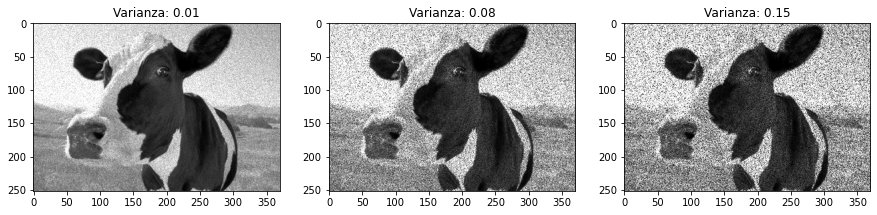

In [210]:
noise_level=np.linspace(0.01,0.15,3)
img_noise_list=[]

fig = plt.figure(1, figsize=[15,int(np.ceil(len(noise_level)/3)*4)])
for i, level in enumerate(noise_level):
    temp=random_noise(img, mode='speckle',mean=0,var=level, seed=42)
    temp=np.array(255*temp, dtype='uint8')
    img_noise_list.append(temp)
    plt.subplot(int(np.ceil(len(noise_level)/3)),3,i+1).imshow(img_noise_list[i],cmap='gray')
    plt.title('Varianza: %.2f' % level)

Se aplica cada uno de los filtros las tres imágenes y se imprimen los resultados.

In [213]:
lee_img_list=[]
kuan_img_list=[]
frost_img_list=[]
for image in img_noise_list:
    lee_img_list.append(lee_filter(image,7,0.5))
    kuan_img_list.append(kuan_filter(image,6,0.5))
    frost_img_list.append(frost_filter(image,damping_factor=6))

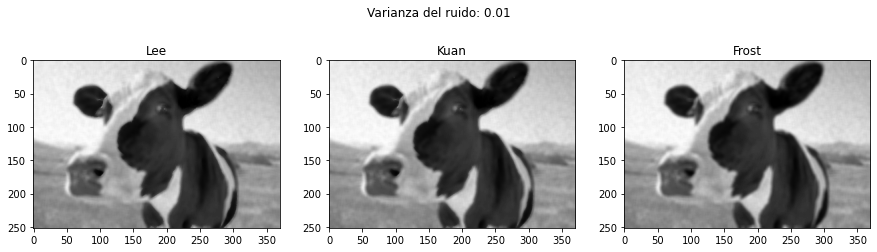

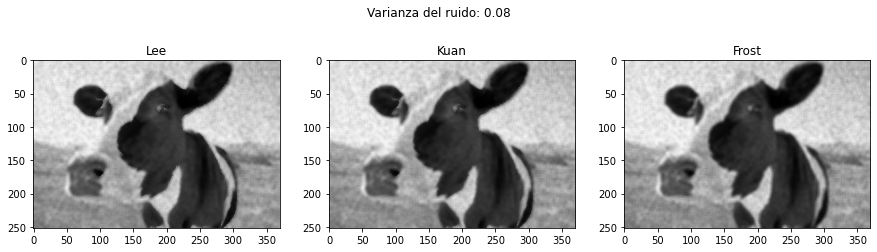

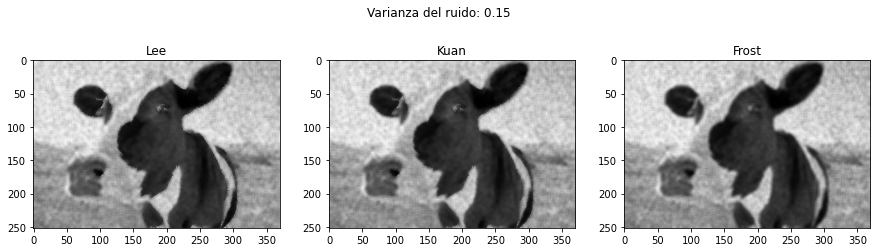

In [214]:
for i, level in enumerate(noise_level):
    fig = plt.figure(i, figsize=[15,int(np.ceil(len(noise_level)/3)*4)])
    fig.suptitle('Varianza del ruido: %.2f' % level)
    plt.subplot(1,3,1).imshow(lee_img_list[i],cmap='gray')
    plt.title('Lee')
    plt.subplot(1,3,2).imshow(kuan_img_list[i],cmap='gray')
    plt.title('Kuan')
    plt.subplot(1,3,3).imshow(frost_img_list[i],cmap='gray')
    plt.title('Frost')

In [216]:
filter_type={"Lee":lee_img_list, "Kuan":kuan_img_list, "Frost":frost_img_list}
for typ in filter_type:
    print('Filtro: ' + typ)
    header='\tVarianza\n'
    snr_line='SNR:'
    enl_line='ENL:'
    ssi_line='SSI:'
    smpi_line='SMPI:'
    q_line='Q:'
    for i,desv in enumerate(noise_level):
        header=header+'\t%.3f'%desv
        snr_line=snr_line+'\t%.3f'%signaltonoise(filter_type[typ][i]);
        enl_line=enl_line+'\t%.1f'%enl(filter_type[typ][i][0:30,340:]);
        ssi_line=ssi_line+'\t%.3f'%SSI(filter_type[typ][i],img_noise_list[i]);
        smpi_line=smpi_line+'\t%.3f'%SMPI(img_noise_list[i],filter_type[typ][i]);
        q_line=q_line+'\t%.3f'%Qfactor(img,filter_type[typ][i]);
    print(header)
    print('-----------------------------')
    print(snr_line)
    print(enl_line)
    print(ssi_line)
    print(smpi_line)
    print(q_line)
    print('')

Filtro: Lee
	Varianza
	0.010	0.080	0.150
-----------------------------
SNR:	1.880	1.931	1.960
ENL:	2052.8	570.3	340.3
SSI:	0.962	0.872	0.805
SMPI:	1.094	1.047	0.992
Q:	1.050	1.107	1.141

Filtro: Kuan
	Varianza
	0.010	0.080	0.150
-----------------------------
SNR:	1.883	1.935	1.966
ENL:	2043.0	569.3	339.3
SSI:	0.961	0.870	0.803
SMPI:	1.034	0.983	0.930
Q:	1.053	1.112	1.148

Filtro: Frost
	Varianza
	0.010	0.080	0.150
-----------------------------
SNR:	1.884	1.938	1.971
ENL:	2017.5	568.3	336.9
SSI:	0.960	0.869	0.801
SMPI:	1.341	1.197	1.065
Q:	1.054	1.115	1.154



Ahora realizamos el mismo procedimiento para una imagen digital donde las areas de color son mas uniformes al ser creadas artificialmente.

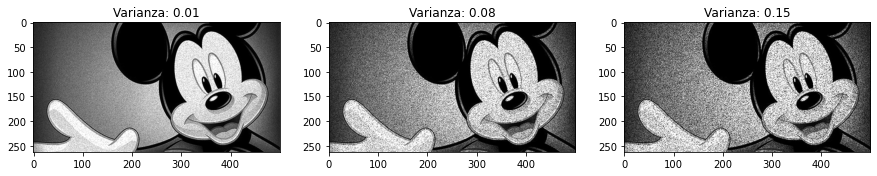

In [52]:
img=cv2.imread('fig/mic.jpg', 0)

noise_level=np.linspace(0.01,0.15,3)
img_noise_list=[]

fig = plt.figure(1, figsize=[15,int(np.ceil(len(noise_level)/3)*4)])
for i, level in enumerate(noise_level):
    temp=random_noise(img, mode='speckle',mean=0,var=level, seed=42)
    temp=np.array(255*temp, dtype='uint8')
    img_noise_list.append(temp)
    plt.subplot(int(np.ceil(len(noise_level)/3)),3,i+1).imshow(img_noise_list[i],cmap='gray')
    plt.title('Varianza: %.2f' % level)

In [53]:
lee_img_list=[]
kuan_img_list=[]
frost_img_list=[]
for image in img_noise_list:
    lee_img_list.append(lee_filter(image,7,0.5))
    kuan_img_list.append(kuan_filter(image,6,0.5))
    frost_img_list.append(frost_filter(image,damping_factor=6))

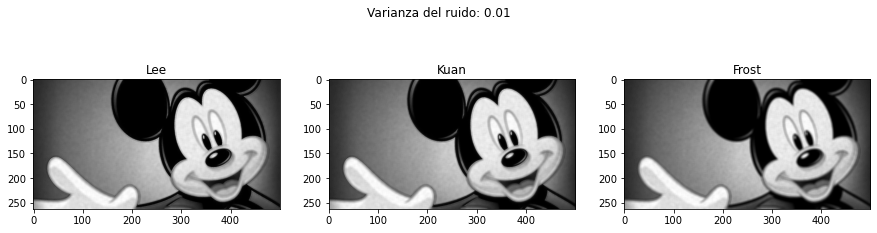

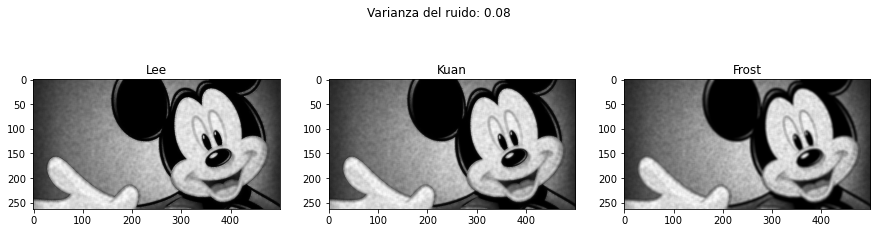

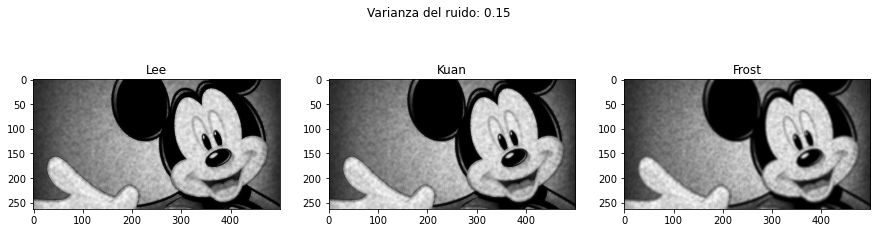

In [37]:
for i, level in enumerate(noise_level):
    fig = plt.figure(i, figsize=[15,int(np.ceil(len(noise_level)/3)*4)])
    fig.suptitle('Varianza del ruido: %.2f' % level)
    plt.subplot(1,3,1).imshow(lee_img_list[i],cmap='gray')
    plt.title('Lee')
    plt.subplot(1,3,2).imshow(kuan_img_list[i],cmap='gray')
    plt.title('Kuan')
    plt.subplot(1,3,3).imshow(frost_img_list[i],cmap='gray')
    plt.title('Frost')

In [47]:
filter_type={"Lee":lee_img_list, "Kuan":kuan_img_list, "Frost":frost_img_list}
for typ in filter_type:
    print('Filtro: ' + typ)
    header='\tVarianza\n'
    snr_line='SNR:'
    enl_line='ENL:'
    ssi_line='SSI:'
    smpi_line='SMPI:'
    q_line='Q:'
    for i,desv in enumerate(noise_level):
        header=header+'\t%.3f'%desv
        snr_line=snr_line+'\t%.3f'%signaltonoise(filter_type[typ][i]);
        enl_line=enl_line+'\t%.1f'%enl(filter_type[typ][i][50:70,300:335]);
        ssi_line=ssi_line+'\t%.3f'%SSI(filter_type[typ][i],img_noise_list[i]);
        smpi_line=smpi_line+'\t%.3f'%SMPI(img_noise_list[i],filter_type[typ][i]);
        q_line=q_line+'\t%.3f'%Qfactor(img,filter_type[typ][i]);
    print(header)
    print('-----------------------------')
    print(snr_line)
    print(enl_line)
    print(ssi_line)
    print(smpi_line)
    print(q_line)
    print('')

Filtro: Lee
	Varianza
	0.010	0.080	0.150
-----------------------------
SNR:	1.393	1.421	1.438
ENL:	6645.7	1146.9	605.9
SSI:	0.968	0.907	0.858
SMPI:	1.934	1.707	1.526
Q:	1.047	1.089	1.115

Filtro: Kuan
	Varianza
	0.010	0.080	0.150
-----------------------------
SNR:	1.403	1.432	1.451
ENL:	6573.3	1141.9	601.3
SSI:	0.962	0.900	0.850
SMPI:	1.754	1.558	1.400
Q:	1.061	1.107	1.135

Filtro: Frost
	Varianza
	0.010	0.080	0.150
-----------------------------
SNR:	1.422	1.453	1.473
ENL:	6440.6	1128.7	597.4
SSI:	0.949	0.888	0.837
SMPI:	1.648	1.532	1.420
Q:	1.091	1.139	1.171



A partir de las mediciones realizadas en imagenes sinteticas y reales podemos establecer que los filtros implementados trabajan de manera adecuada para la eliminación del ruido, en donde se vio un mejor desempeño para imagenes sinteticas sobre las imagenes reales.